# Symmetrical Amplifier

In this notebook the circuit shown in the following schematic will be sized to acheive a certain gain.
The resulting procedure takes a target gain as input and can be run for any technology, for which trained models are available.

![Symmetrical Operatrional Amplifier](./fig/sym.png)



In [1]:
%matplotlib inline

In [44]:
import os
import torch
import numpy as np
import torch as pt
import pandas as pd
import joblib as jl
from functools import partial
from scipy.interpolate import pchip_interpolate, interp1d
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, minmax_scale

from skopt import Optimizer, gp_minimize
from skopt.space import Real
from skopt.plots import plot_convergence, plot_gaussian_process

## Specification

The overall performance of the circuit is approximated during sizing by

$$A_{0} \approx M \cdot \frac{g_{\mathrm{m}, \mathtt{d}}}{g_{\mathrm{ds},\mathtt{cm22}} + g_{\mathrm{ds},\mathtt{cm32}}}$$

and 

$$ f_{0} \approx \frac{g_{\mathrm{ds},\mathtt{cm22}} + g_{\mathrm{ds},\mathtt{cm32}}}{2 \cdot \pi \cdot C_{L}} $$

At the end these performances are verified by simulation.

| Parameter             | Specification |
|-----------------------|--------------:|
| $V_{\mathrm{DD}}$     |      $1.2\,V$ |
| $V_{\mathrm{in,cm}}$  |      $0.6\,V$ |
| $V_{\mathrm{out,cm}}$ |      $0.6\,V$ |
| $I_{\mathtt{B0}}$     |   $10\,\mu A$ |
| $C_{\mathrm{L}}$      |     $10\,p F$ |

In [3]:
V_DD  = 1.2
V_SS  = 0.0
V_ICM = 0.6
V_OCM = 0.6
I_B0  = 10e-6
C_L   = 10e-12

## Simulator Setup

[PySpice]() is used for verifying the design by simulation within this notebook.

In [4]:
import logging
from PySpice.Spice.Netlist import Circuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *

The Symmetrical amplifier is setup as a subcircuit to be included into a testbench.

In [5]:
class SymAmp(SubCircuitFactory):
    NAME = "symamp"
    NODES = (10, 11, 12, 13, 14, 15)
    
    def __init__(self):
        super().__init__()
        # Biasing Current Mirror
        self.MOSFET("NCM11" , 10, 10, 14, 14, model = "nmos")
        self.MOSFET("NCM12" , 16, 10, 14, 14, model = "nmos")
        # Differential Pair
        self.MOSFET("ND11"  , 17, 12, 16, 14, model = "nmos")
        self.MOSFET("ND12"  , 18, 11, 16, 14, model = "nmos")
        # PMOS Current Mirrors
        self.MOSFET("PCM221", 17, 17, 15, 15, model = "pmos")
        self.MOSFET("PCM222", 19, 17, 15, 15, model = "pmos")
        self.MOSFET("PCM211", 18, 18, 15, 15, model = "pmos")
        self.MOSFET("PCM212", 13, 18, 15, 15, model = "pmos")
        # NMOS Current Mirror
        self.MOSFET("NCM31" , 19, 19, 14, 14, model = "nmos")
        self.MOSFET("NCM32" , 13, 19, 14, 14, model = "nmos")

The subckt as well as the MOS library have to be specified in the netlist. This is where changes need to be made if another technology is to be sized.

In [6]:
spice_library = SpiceLibrary("../lib/90nm_bulk.lib")
netlist = Circuit("symamp_tb")
netlist.include(spice_library["nmos"])
netlist.subcircuit(SymAmp())

The Open Loop Gain is obtained through the following Testbench.

In [7]:
netlist.X("sym", "symamp", "B", "P", "N", "O", 0, "D")
symamp = list(netlist.subcircuits)[0]
i_ref  = netlist.CurrentSource("ref",  0 , "B", I_B0@u_A)
v_dd   = netlist.VoltageSource("dd" , "D",  0 , V_DD@u_V)
v_ip   = netlist.VoltageSource("ip" , "P",  0 , V_ICM@u_V)
v_in   = netlist.SinusoidalVoltageSource( "in", "N", "E"
                                        , dc_offset=0.0@u_V
                                        , ac_magnitude=-1.0@u_V
                                        , )
e_buf  = netlist.VoltageControlledVoltageSource("in", "E", 0, "O", 0, 1.0@u_V)
c_l    = netlist.C("L", "O", 0, C_L@u_F)

The simulation function takes a `dict` with a key for each device in the circuit and at least columns `W` and `L` for sizing. It returns the performances obtained through an AC Analysis.

In [8]:
def simulate(device_paramters):
    for device, parameters in device_paramters.items():
        symamp.element(device).width  = parameters["W"].values[0]
        symamp.element(device).length = parameters["L"].values[0]
        
    simulator = netlist.simulator( simulator="ngspice-subprocess"
                                 , temperature=27
                                 , nominal_temperature=27
                                 , )

    logging.disable(logging.FATAL)
    analysis  = simulator.ac( start_frequency  = 1.0@u_Hz
                            , stop_frequency   = 1e11@u_Hz
                            , number_of_points = 10
                            , variation        = "dec"
                            , )
    
    freq  = np.array(analysis.frequency)
    gain  = (20 * np.log10(np.absolute(analysis["O"]))) - (20 * np.log10(np.absolute(analysis["N"])))
    phase = np.angle(analysis["O"], deg=True) - np.angle(analysis["N"], deg=True)
    logging.disable(logging.NOTSET)
    
    gf = [gain[np.argsort(gain)], freq[np.argsort(gain)]]
    pf = [phase[np.argsort(phase)], freq[np.argsort(phase)]]
    
    A0dB = pchip_interpolate(freq, gain, [1.0])
    A3dB = A0dB - 3.0
    f3dB = pchip_interpolate(*gf, [A3dB])
    
    fug = pchip_interpolate(*gf, [0.0]) if A0dB > 0 else np.ones(1)
    fp0 = pchip_interpolate(*pf, [0.0])
    
    PM = pchip_interpolate(freq, phase, [fug]) if A0dB > 0 else np.zeros(1)
    GM = pchip_interpolate(freq, gain, [fp0])
    
    performances = { "A0dB" : A0dB.item() 
                   , "f3dB" : f3dB.item()
                   , "fug"  : fug.item()
                   , "PM"   : PM.item()
                   , "GM"   : GM.item()
                   , }
    
    return performances

## Device Model Setup

The `PrimitiveDevice` class acts as interface to the machine learning models. With this, multiple models of different types and technologies can be instantiatede and compared.

In [21]:
class PrimitiveDevice():
    def __init__(self, prefix, params_x, params_y):
        self.prefix   = prefix
        self.params_x = params_x
        self.params_y = params_y
        
        self.model = pt.jit.load(f"{self.prefix}/model.pt")
        self.model.cpu()
        self.model.eval()
        
        self.scale_x = jl.load(f"{self.prefix}/scale.X")
        self.scale_y = jl.load(f"{self.prefix}/scale.Y")
        
    def predict(self, X):
        with pt.no_grad():
            X.fug = np.log10(X.fug.values)
            X_ = self.scale_x.transform(X[params_x].values)
            Y_ = self.model(pt.from_numpy(np.float32(X_))).numpy()
            Y  = pd.DataFrame( self.scale_y.inverse_transform(Y_)
                             , columns=params_y )
            Y.jd   = np.power(10, Y.jd.values)
            Y.gdsw = np.power(10, Y.gdsw.values)
        return pd.DataFrame(Y, columns=self.params_y)

The circuit is not divided into single devices, but rather in _building blocks_ as indicated by the dashed boxes in the schematic.

In [22]:
devices           = [ "MNCM11", "MNCM12", "MND11", "MND12", "MNCM31", "MNCM32"
                    , "MPCM221" , "MPCM222", "MPCM211", "MPCM212" ]
reference_devices = [ "MNCM12", "MND12", "MPCM212", "MNCM32" ]

The inputs and outputs of the model, trained in `model_training.ipynb` have to specified again.

In [23]:
params_x = ["gmid", "fug", "Vds", "Vbs"]
params_y = ["jd", "L", "gdsw", "Vgs"]

Initially the symmetrical amplifier is sized with the models for the $90\,\mathrm{nm}$ technology. 
Later this can be changed to any other technology model, yielding similar results.

In [24]:
nmos = PrimitiveDevice("../models/example/90nm-nmos", params_x, params_y)
pmos = PrimitiveDevice("../models/example/90nm-pmos", params_x, params_y)

## Design Procedure

![Symmetrical Amplifier](./fig/sym.png)

For simplicity in this example, only the $\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}$ dependend models
are considered. Therefore, sizing for all devices is expressed in terms of 
$\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}$ and $f_{\mathrm{ug}}$.

$$\gamma_{\mathrm{n,p}} \left ( \left [ \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}, f_{\mathrm{ug}}, V_{\mathrm{ds}}, V_{\mathrm{bs}} \right ]^{\dagger} \right ) 
\Rightarrow \left [ L, \frac{I_{\mathrm{d}}}{W}, \frac{g_{\mathrm{ds}}}{W}, V_{\mathrm{gs}} \right ]^{\dagger}
$$

First, the specification, given in the table above is considered,
from which a biasing current ${I_{\mathtt{B1}} = \frac{I_{\mathrm{B0}}}{2}}$ is defined.
This, in turn results in a mirror ratio $M_{\mathrm{n}} = 2 : 1$ of the NMOS current mirror `NCM1`.
Additionally, the ratio $M_{\mathrm{p}} = 1 : 4$ of the PMOS current mirrors `MPCM2` is specified. 
Usually, this is chosen to balance power consumption and phase margin. Since this
has to be analyzed separately by simulation, starting values ${M_{\mathtt{cm21}} = 1}$ 
and ${M_{\mathtt{cm22}} = 4}$ are selected. Furthermore, the remaining branch current
$I_{\mathtt{B2}} = M_{\mathrm{p}} \cdot \frac{I_{\mathtt{B2}}}{2}$ is determined.

In [25]:
M_P  = 4
M_N  = 2
I_B1 = I_B0 / M_N
I_B2 = (I_B1 / 2) * M_P

Since the common mode output voltage $V_{\mathrm{out,cm}} = 0.6$ is known, the sizing procedure starts with `MPCM212`:

$$ \gamma_{\mathrm{p}, \mathtt{MPCM2}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MPCM2}}
                                                     , f_{\mathrm{ug}, \mathtt{MPCM2}}, (V_{\mathrm{DD}} - V_{\mathrm{out,cm}}), 0.0 \right ]^{\dagger} 
                       \right ) $$

The gate voltage $V_{\mathrm{gs}, \mathtt{MPCM}}$ helps guiding the sizing for the differential pair later.
Next, `MNCM32` is considered with:

$$ \gamma_{\mathrm{n}, \mathtt{MNCM3}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MNCM3}}
                                                      , f_{\mathrm{ug}, \mathtt{MNCM3}}, V_{\mathrm{out,cm}}, 0.0 \right ]^{\dagger} 
                       \right ) $$

Sizing the differential pair requires, _guessing_ $V_{\mathrm{x}} = 0.25\,\mathrm{V}$ which is done by considering 
the fact that 3 devices are stacked and it merely serves as biasing. Therefore:

$$ \gamma_{\mathrm{n}, \mathtt{MND1}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MND1}}
                                                      , f_{\mathrm{ug}, \mathtt{MND1}}
                                                      , (V_{\mathrm{DD}} -  V_{\mathrm{gs}, \mathtt{MPCM}} - V_{\mathrm{x}})
                                                      , - V_{\mathrm{x}} \right ]^{\dagger} 
                       \right ) $$

Subsequently, the biasing current mirror `MNCM3` is sized:

$$ \gamma_{\mathrm{n}, \mathtt{MNCM3}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MNCM3}}
                                                      , f_{\mathrm{ug}, \mathtt{MNCM3}}
                                                      , V_{\mathrm{x}}
                                                      , 0.0 \right ]^{\dagger} 
                       \right ) $$



With these four function calls, the sizing of the entire circuit is expressed in terms of eight electrical characteristics.
The following function `symamp_sizing` takes a `dict` with keys for each _reference device_ $\in$ `reference_devices = [ "MNCM12", "MND12", "MPCM212", "MNCM32" ]` and corresponding, desired characteristics. The obtained sizing for each device is propageted to related devices in the same building block and a new `dict` with sizing information is returned.

In [26]:
def symamp_sizing( gmid_ncm12, gmid_ndp12, gmid_pcm212, gmid_ncm32 
                 , fug_ncm12, fug_ndp12, fug_pcm212, fug_ncm32 ):
    
    ec                 = {}
    
    ## PMOS Current Mirror MPCM2:
    input_pcm212       = pd.DataFrame( np.array([[gmid_pcm212, fug_pcm212, (V_DD - V_OCM), 0.0]])
                                     , columns=params_x )
    ec["MPCM212"]      = pmos.predict(input_pcm212).join(input_pcm212)
    # Determine width based on known branch current
    ec["MPCM212"]["W"] = I_B2 / ec["MPCM212"].jd     
    # Copy to related device, don't overwrite
    ec["MPCM221"]      = ec["MPCM212"].copy()     
    # MPCM211's width has to be reduced by M_P 
    ec["MPCM221"].W    = ec["MPCM221"].W / M_P    
    # Size MPCM222 and MPCM211 accordingly
    ec["MPCM222"]      = ec["MPCM212"]
    ec["MPCM211"]      = ec["MPCM221"]
    
    ## NMOS Current Mirror NCM3:
    input_ncm32        = pd.DataFrame( np.array([[gmid_ncm32, fug_ncm32, V_OCM, 0.0]])
                                     , columns=params_x )
    ec["MNCM32"]       = nmos.predict(input_ncm32).join(input_ncm32)
    ec["MNCM32"]["W"]  = I_B2 / ec["MNCM32"].jd
    ec["MNCM31"]       = ec["MNCM32"].copy()
    
    ## NMOS Differential Pair NDP1:
    V_X                = 0.23
    V_GS               = ec["MNCM32"].Vgs.values[0]
    input_nd12         = pd.DataFrame( np.array([[gmid_ndp12, fug_ndp12, (V_DD - V_GS - V_X), -V_X]])
                                     , columns=params_x )
    ec["MND12"]        = nmos.predict(input_nd12).join(input_nd12)
    ec["MND12"]["W"]   = (I_B1 / 2) / ec["MND12"].jd
    ec["MND11"]        = ec["MND12"].copy()
    
    ## NMOS Current Mirror NCM1
    input_ncm12        = pd.DataFrame( np.array([[gmid_ncm12, fug_ncm12, V_X, 0.0]])
                                     , columns=params_x )
    ec["MNCM12"]       = nmos.predict(input_ncm12).join(input_ncm12)
    ec["MNCM12"]["W"]  = I_B1 / ec["MNCM12"].jd
    ec["MNCM11"]       = ec["MNCM12"].copy()
    # MNCM11's width has to be adjusted by M_N
    ec["MNCM11"].W     = ec["MNCM11"].W * M_N
    
    ## Calculate/Approximate Operating point Parameters
    for dev,val in ec.items():
        val["gds"] = val.gdsw * val.W
        val["id"]  = val.jd * val.W
        val["gm"]  = val.gmid * val.id
    
    return ec

To make it more useable in an optimization context, a wrapper function that takes the 8 individual characteristics for the 4 _reference devices_ and returns a performance estimate is set up here with `symamp_performance`.

In [27]:
def symamp_performance( gmid_ncm12, gmid_ndp12, gmid_pcm212, gmid_ncm32
                      , fug_ncm12, fug_ndp12, fug_pcm212, fug_ncm32 ):
    dc = symamp_sizing( gmid_ncm12, gmid_ndp12, gmid_pcm212, gmid_ncm32
                      , fug_ncm12, fug_ndp12, fug_pcm212, fug_ncm32 )
    A0dB = 20 * np.log10(M_P * (dc["MND12"].gm / (dc["MNCM32"].gds + dc["MPCM212"].gds)).values[0])
    f3dB = ((dc["MNCM32"].gds + dc["MPCM212"].gds).values[0] / (2 * np.pi * C_L))
    return [A0dB, f3dB]

As described in the Paper, after wrapping the performnace estimate into a function of electrical characteristics, 
the $\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} = 10.0\,\mathrm{V}^{-1}$ for all devices is **fixed**, 
which is expressed by $p_{\mathrm{sym}}$ (`p_sym`) here.

In [57]:
p_sym = partial(symamp_performance, 7.0, 10.0, 10.0, 10.0)

The optimization target / cost function `c_sym` is defined in terms of the desired target gain.

In [67]:
A0dB_target = 40

In [68]:
res = gp_minimize( lambda f: np.abs(p_sym(*f)[0] - A0dB_target)
                 , [(1e6,1e11), (1e6,1e11), (1e6,1e11), (1e6,1e11)]
                 , n_calls=50
                 , n_random_starts=7
                 , noise=0.0
                 , acq_func="EI" # EI, PI, LCB
                 , )

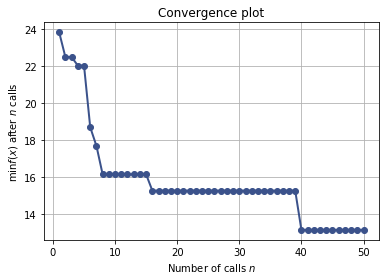

In [61]:
plot_convergence(res)

In [60]:
res

          fun: 13.142711088448095
    func_vals: array([23.83794025, 22.49792415, 23.59123411, 22.03532456, 23.00558341,
       18.69491468, 17.68919504, 16.1469742 , 16.75638382, 20.89467792,
       16.1469742 , 20.06132382, 16.1469742 , 16.21717918, 21.0606925 ,
       15.26828911, 17.74656273, 18.48609808, 18.09064645, 18.45038244,
       20.34554479, 17.73593131, 18.2427696 , 16.18490865, 16.46223472,
       16.35780368, 16.91834134, 18.85167094, 17.72468551, 20.37034755,
       18.11096779, 16.1469742 , 18.43001919, 18.23316897, 18.41810019,
       18.18209154, 18.09409653, 16.25034973, 18.52174593, 13.14271109,
       16.70109353, 16.72561475, 16.66105681, 16.16759728, 13.66022388,
       16.68505085, 15.48864125, 16.70027357, 14.53101329, 17.97418162])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5),
                         n_restarts_optimizer=2, noise=0.0, normalize_y=True,
                         random_state=1055964965), Gau

In [66]:
from yabox import PDE
c_sym = lambda f: np.abs(p_sym(*f)[0] - A0dB_target)
problem = PDE( c_sym
             , [(1e6,1e11), (1e6,1e11), (1e6,1e11), (1e6,1e11)])
x,y = problem.solve(show_progress=True)

Optimizing (Parallel DE):   0%|          | 0/1000 [00:00<?, ?it/s]

PicklingError: Can't pickle <function <lambda> at 0x7eff691cf310>: attribute lookup <lambda> on __main__ failed

In [34]:
for device, parameters in device_characteristics.items():
    symamp.element(device).width  = parameters["W"].values[0]
    symamp.element(device).length = parameters["L"].values[0]

NameError: name 'device_characteristics' is not defined

In [ ]:
logging.disable(logging.FATAL)
simulator = netlist.simulator( simulator="ngspice-subprocess"
                             , temperature=27
                             , nominal_temperature=27
                             , )

analysis  = simulator.ac( start_frequency  = 1.0@u_Hz
                        , stop_frequency   = 1e11@u_Hz
                        , number_of_points = 10
                        , variation        = "dec"
                        , )
logging.disable(logging.NOTSET)

In [ ]:
print(simulator)

In [ ]:
simulator = netlist.simulator( simulator="ngspice-subprocess"
                             , temperature=27
                             , nominal_temperature=27
                             , )

logging.disable(logging.FATAL)
analysis  = simulator.ac( start_frequency  = 1.0@u_Hz
                        , stop_frequency   = 1e11@u_Hz
                        , number_of_points = 10
                        , variation        = "dec"
                        , )

freq  = np.array(analysis.frequency)
gain  = (20 * np.log10(np.absolute(analysis["O"]))) - (20 * np.log10(np.absolute(analysis["N"])))
phase = np.angle(analysis["O"], deg=True) - np.angle(analysis["N"], deg=True)
logging.disable(logging.NOTSET)

In [ ]:
fig = plt.figure()
plt.plot(freq, gain) # (20 * np.log10(np.absolute(analysis["O"]))))
plt.xscale("log")

In [ ]:
print(simulator)

In [ ]:
gf = [gain[np.argsort(gain)], freq[np.argsort(gain)]]
pf = [phase[np.argsort(phase)], freq[np.argsort(phase)]]

A0dB = pchip_interpolate(freq, gain, [1.0])
A3dB = A0dB - 3.0
f3dB = pchip_interpolate(*gf, [A3dB])

fug = pchip_interpolate(*gf, [0.0]) if A0dB > 0 else np.ones(1)
fp0 = pchip_interpolate(*pf, [0.0])

PM = pchip_interpolate(freq, phase, [fug]) if A0dB > 0 else np.zeros(1)
GM = pchip_interpolate(freq, gain, [fp0])

performance = { "A0dB" : A0dB.item() 
              , "f3dB" : f3dB.item()
              , "fug"  : fug.item()
              , "PM"   : PM.item()
              , "GM"   : GM.item()
              , }


In [ ]:
performance